In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
%cd content
!mkdir data
!cp /content/gdrive/MyDrive/Classification/FSL_City/data/images_train ./
!cp /content/gdrive/MyDrive/Classification/FSL_City/data/labels_train ./
!cp /content/gdrive/MyDrive/Classification/FSL_City/data/images_test ./
!cp /content/gdrive/MyDrive/Classification/FSL_City/data/labels_test ./
# !cp /content/gdrive/MyDrive/Classification/FSL_City/data/train.zip ./
# !cp /content/gdrive/MyDrive/Classification/FSL_City/data/valid.zip ./
# !unzip ./train.zip -d data/
# !unzip ./valid.zip -d data/

/
Mounted at /content/gdrive
/content
cp: cannot stat '/content/gdrive/MyDrive/Classification/FSL_City/data/train.zip': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/Classification/FSL_City/data/valid.zip': No such file or directory
unzip:  cannot find or open ./train.zip, ./train.zip.zip or ./train.zip.ZIP.
unzip:  cannot find or open ./valid.zip, ./valid.zip.zip or ./valid.zip.ZIP.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import pickle
import numpy as np
import cv2

with open("images_train", "rb") as fp:
   trainx = pickle.load(fp)
   trainx = np.array(trainx)
with open("labels_train", "rb") as fp:
   trainy = pickle.load(fp)
   trainy = np.array(trainy)
with open("images_test", "rb") as fp:
   testx = pickle.load(fp)
   testx = np.array(testx)
with open("labels_test", "rb") as fp:
   testy = pickle.load(fp)
   testy = np.array(testy)

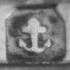

In [4]:
from google.colab.patches import cv2_imshow
cv2_imshow(trainx[0])

In [5]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((90, 70, 70, 3), (90,), (1302, 70, 70, 3), (1302,))

In [73]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)

  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [82]:
import torchvision
import matplotlib.pyplot as plt

def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

let's pick a sample and display it

*   n_way = 9
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


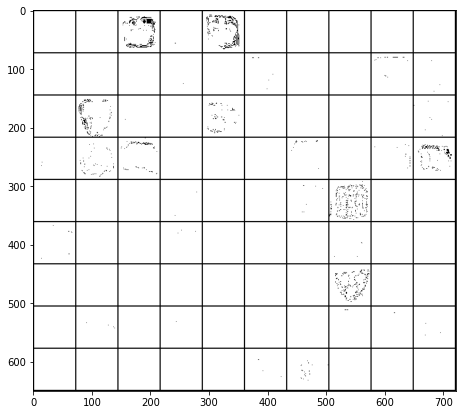

In [83]:
import torch

sample_example = extract_sample(9, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [9]:
sample_example['images'].shape

torch.Size([9, 10, 3, 70, 70])

In [20]:
from torch import nn

class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [25]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [26]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [27]:
from tqdm import tqdm_notebook
from tqdm import tnrange
from torch import optim

def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [88]:
%%time

model = load_protonet_conv(
    x_dim=(3,70,70),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 9
n_support = 2
n_query = 8

train_x = trainx
train_y = trainy

max_epoch = 6
epoch_size = 500

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 1 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 -- Loss: 2.0395 Acc: 0.9555


Epoch 2 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0001 Acc: 1.0000


Epoch 3 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0001 Acc: 1.0000


Epoch 4 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0001 Acc: 1.0000


Epoch 5 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0001 Acc: 1.0000


Epoch 6 train:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 -- Loss: 0.0000 Acc: 1.0000
CPU times: user 3min 19s, sys: 2 s, total: 3min 21s
Wall time: 3min 20s


In [89]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [90]:
n_way = 9
n_support = 20
n_query = 20

test_x = testx
test_y = testy

test_episode = 500

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


  0%|          | 0/500 [00:00<?, ?it/s]

Test results -- Loss: 3.1560 Acc: 0.3942


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


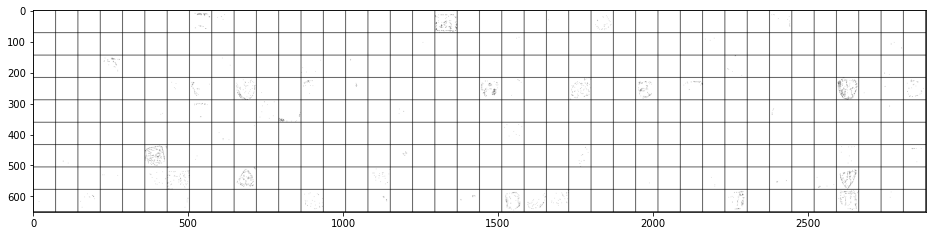

In [91]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [92]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [93]:
my_output

{'acc': 0.41111111640930176,
 'loss': 3.251396656036377,
 'y_hat': tensor([[8, 0, 0, 2, 1, 7, 4, 0, 0, 8, 5, 8, 0, 0, 0, 6, 0, 3, 6, 0],
         [4, 1, 6, 8, 1, 0, 2, 4, 1, 1, 1, 1, 2, 4, 1, 4, 6, 1, 2, 5],
         [2, 1, 6, 2, 0, 8, 6, 2, 2, 4, 8, 0, 4, 2, 1, 4, 5, 0, 2, 3],
         [3, 3, 6, 1, 2, 1, 7, 0, 3, 7, 7, 4, 4, 2, 7, 3, 3, 3, 7, 0],
         [4, 4, 4, 5, 1, 1, 4, 4, 4, 4, 8, 4, 4, 2, 6, 2, 8, 1, 1, 8],
         [1, 0, 5, 4, 1, 5, 1, 2, 1, 4, 4, 5, 1, 5, 4, 2, 1, 5, 7, 4],
         [6, 1, 4, 6, 6, 4, 5, 3, 4, 0, 6, 6, 6, 6, 6, 4, 6, 6, 2, 4],
         [7, 5, 1, 0, 1, 4, 4, 7, 7, 0, 7, 7, 7, 7, 1, 7, 7, 3, 7, 1],
         [7, 7, 4, 7, 8, 8, 1, 8, 8, 8, 8, 2, 8, 8, 8, 6, 7, 5, 8, 8]],
        device='cuda:0')}